In [14]:
%load_ext autoreload
%autoreload 2
# 
from srf.helpers import evar,add_noise_with_snr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tools.rsa import compute_similarity
from srf.mixed.admm import admm_symnmf_masked, train_val_split, ADMM, find_best_rank
from srf.datasets import load_dataset
from srf.helpers import median_matrix_split, best_pairwise_match, zero_matrix_split
from srf.plotting import plot_images_from_embedding
import seaborn as sns
import pandas as pd

def plot_rank_selection(df_full, df_pos, df_neg):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    # Plot full dataframes with variance across repeats
    sns.lineplot(data=df_full, x="rank", y="rmse", ax=ax1, errorbar="sd")
    ax1.set_title("Full RSM")
    ax1.axvline(
        x=df_full.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )

    sns.lineplot(data=df_pos, x="rank", y="rmse", ax=ax2, errorbar="sd")
    ax2.set_title("Positive")
    ax2.axvline(
        x=df_pos.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )

    sns.lineplot(data=df_neg, x="rank", y="rmse", ax=ax3, errorbar="sd")
    ax3.set_title("Negative")
    ax3.axvline(
        x=df_neg.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )


    plt.tight_layout()
    plt.show()

    # Calculate best ranks using mean RMSE
    rank_pos = df_pos.groupby("rank")["rmse"].mean().idxmin()
    rank_neg = df_neg.groupby("rank")["rmse"].mean().idxmin()
    rank_all = df_full.groupby("rank")["rmse"].mean().idxmin()

    print(f"best rank for positive matrix: {rank_pos}")
    print(f"best rank for negative matrix: {rank_neg}")
    print(f"best rank for all matrix: {rank_all}")

In [3]:
dataset.rsm.shape

(120, 120)

fraction of positive values: 0.5168055555555555


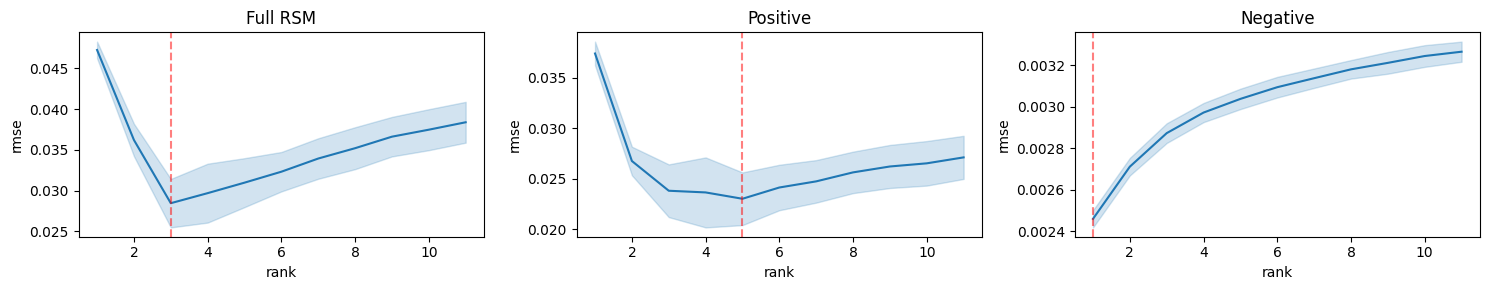

best rank for positive matrix: 5
best rank for negative matrix: 1
best rank for all matrix: 3


In [7]:
dataset = load_dataset("peterson-animals")

images = dataset.images
rsm = dataset.rsm
n = rsm.shape[0]
repeats = 50
s_plus, s_minus, thresh, mask = median_matrix_split(rsm)

ratio = 0.2
df_full = find_best_rank(
    rsm,
    range(1, 12),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)
df_pos = find_best_rank(
    s_plus,
    range(1, 12),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)
df_neg = find_best_rank(
    s_minus,
    range(1, 12),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)

plot_rank_selection(df_full, df_pos, df_neg)

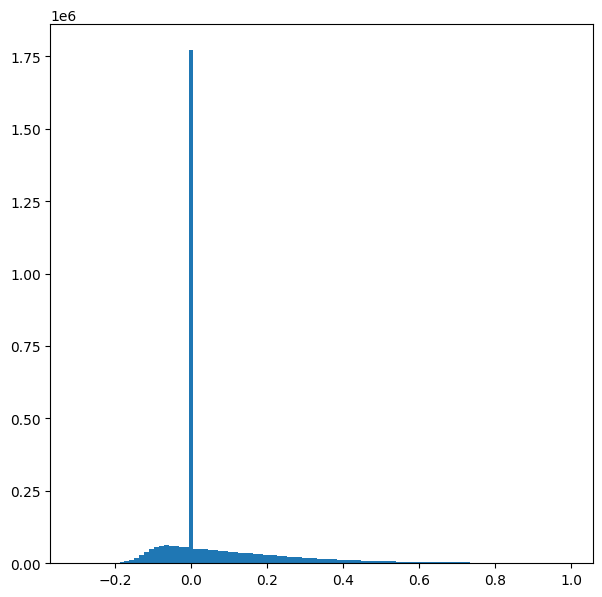

fraction of positive values: 0.6501206173654095


/LOCAL/fmahner/srf/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/LOCAL/fmahner/srf/.venv/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/LOCAL/fmahner/srf/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/LOCAL/fmahner/srf/.venv/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/LOCAL/fmahner/srf/.venv/lib/python3.10/site-packages/seaborn/matrix.py:

<Figure size 700x700 with 0 Axes>

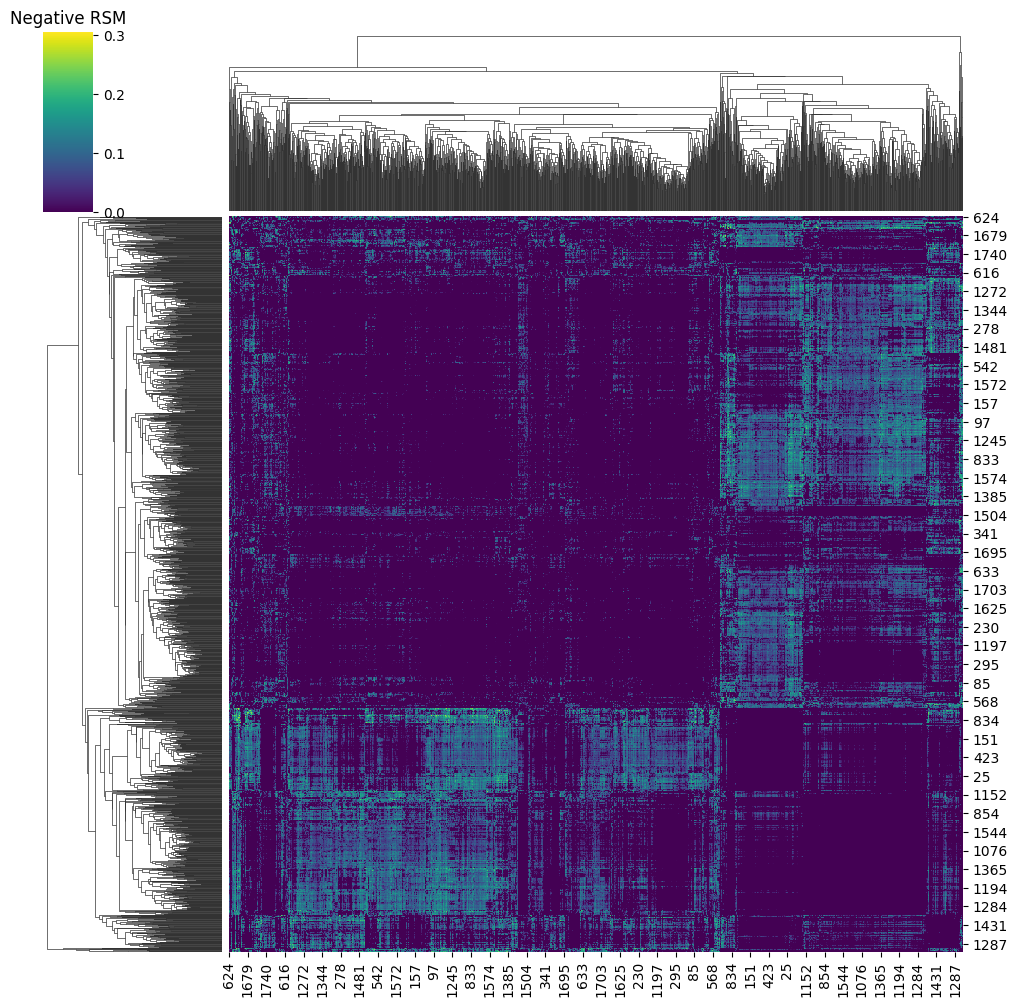

<Figure size 700x700 with 0 Axes>

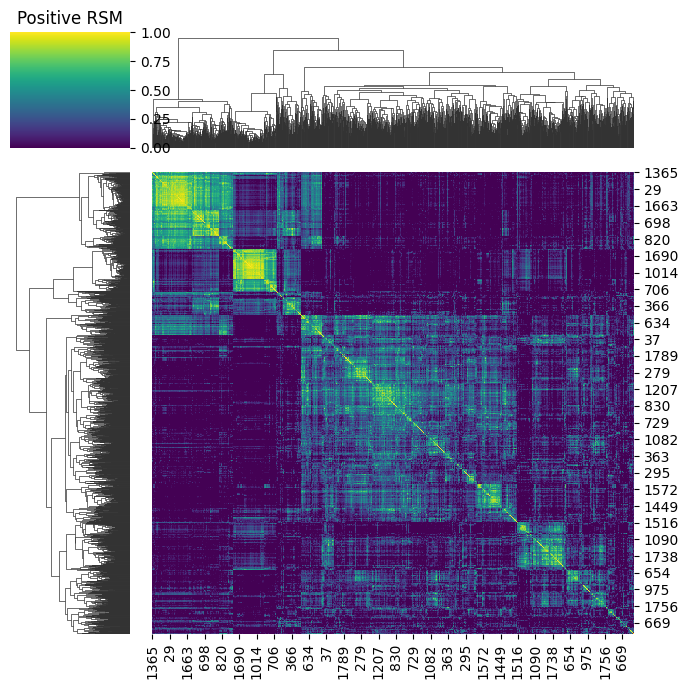

In [ ]:
import seaborn as sns
import numpy as np
from srf.datasets import load_dataset

dataset = load_dataset("peterson-animals")

images = dataset.images
# rsm = dataset.rsm
x = np.loadtxt("/LOCAL/fmahner/srf/data/misc/spose_embedding_66d.txt")
rsm = compute_similarity(x, x, "pearson")
n = rsm.shape[0]
plt.figure(figsize=(7, 7))
plt.hist(np.triu(rsm, k=1).flatten(), bins=100)
plt.show()
repeats = 50
s_plus, s_minus, thresh, mask = median_matrix_split(rsm)
# s_plus, s_minus, thresh, mask = zero_matrix_split(rsm)

s_minus = s_minus - np.mins_minus)

plt.figure(figsize=(7, 7))
sns.clustermap(
    s_minus,
    cmap="viridis",
)
plt.title("Negative RSM")
plt.figure(figsize=(7, 7))
sns.clustermap(s_plus, cmap="viridis", figsize=(7, 7))
plt.title("Positive RSM")
plt.tight_layout()

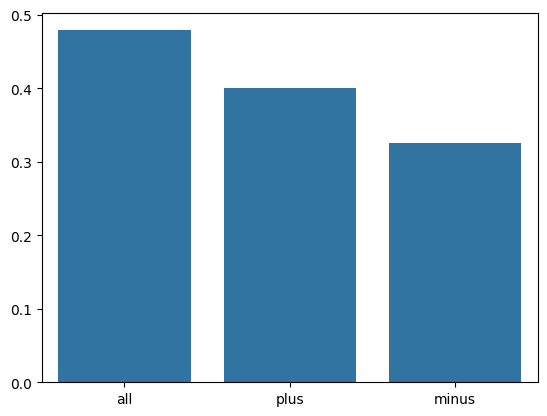

In [31]:
model = ADMM(rank=2, max_outer=10, w_inner=40, tol=0.0, verbose=False)
mask = np.ones_like(rsm)
model.fit(rsm, mask=mask)
evar_all = model.history_["evar"][-1]
model.fit(s_minus, mask=mask)
evar_minus = model.history_["evar"][-1]
model.fit(s_plus, mask=mask)
evar_plus = model.history_["evar"][-1]

# make a seaborn bar plot of the explain variance of the three matrices
sns.barplot(x=["all", "plus", "minus"], y=[evar_all, evar_plus, evar_minus])
plt.show()

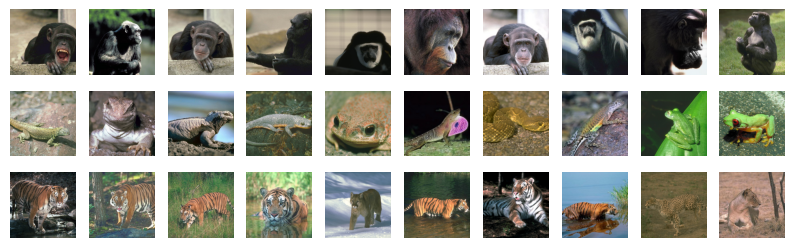

In [12]:
model = ADMM(rank=3, max_outer=50, w_inner=100, tol=0.0, verbose=True, rho=2.0)

w = model.fit_transform(rsm)

fig = plot_images_from_embedding(w, images, top_k=10, dpi=100)

# w_plus = model.fit_transform(s_plus)
# w_minus = model.fit_transform(s_minus)

# fig = plot_images_from_embedding(w_plus, images, top_k=10, dpi=100)
# fig = plot_images_from_embedding(w_minus, images, top_k=10, dpi=100)

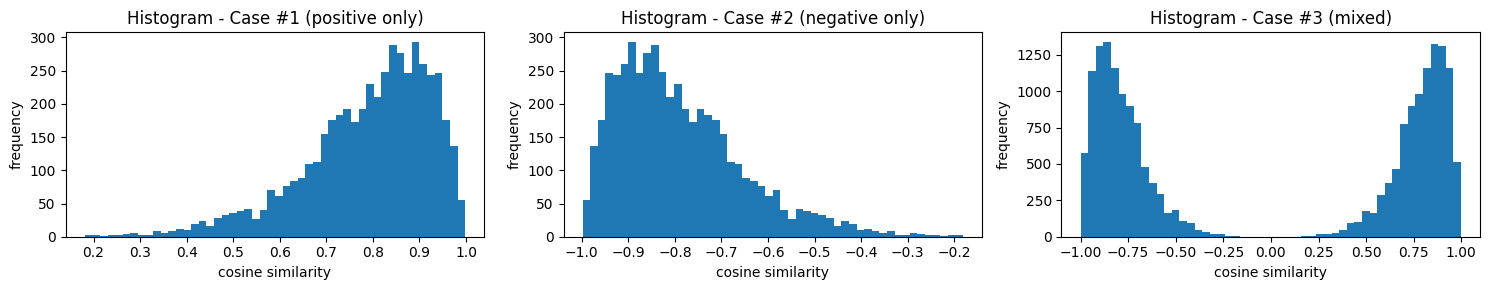

In [15]:
import numpy as np
import matplotlib.pyplot as plt

n_each = 100
dim = 5
bins = 50
rng = np.random.default_rng(0)

x_pos = rng.random((n_each, dim))
x_pos /= np.linalg.norm(x_pos, axis=1, keepdims=True)

x_neg = -x_pos
x_neg /= np.linalg.norm(x_neg, axis=1, keepdims=True)

rsm_pos = x_pos @ x_pos.T
rsm_neg = x_pos @ x_neg.T
x_all = np.vstack([x_pos, x_neg])
rsm_all = x_all @ x_all.T


def upper(vec):
    return vec[np.triu_indices_from(vec, k=1)]


fig, axes = plt.subplots(1, 3, figsize=(15, 3))

axes[0].hist(upper(rsm_pos), bins=bins)
axes[0].set_title("Histogram - Case #1 (positive only)")
axes[0].set_xlabel("cosine similarity")
axes[0].set_ylabel("frequency")

axes[1].hist(upper(rsm_neg), bins=bins)
axes[1].set_title("Histogram - Case #2 (negative only)")
axes[1].set_xlabel("cosine similarity")
axes[1].set_ylabel("frequency")

axes[2].hist(upper(rsm_all), bins=bins)
axes[2].set_title("Histogram - Case #3 (mixed)")
axes[2].set_xlabel("cosine similarity")
axes[2].set_ylabel("frequency")


plt.tight_layout()
plt.show()

fraction of positive values: 0.5


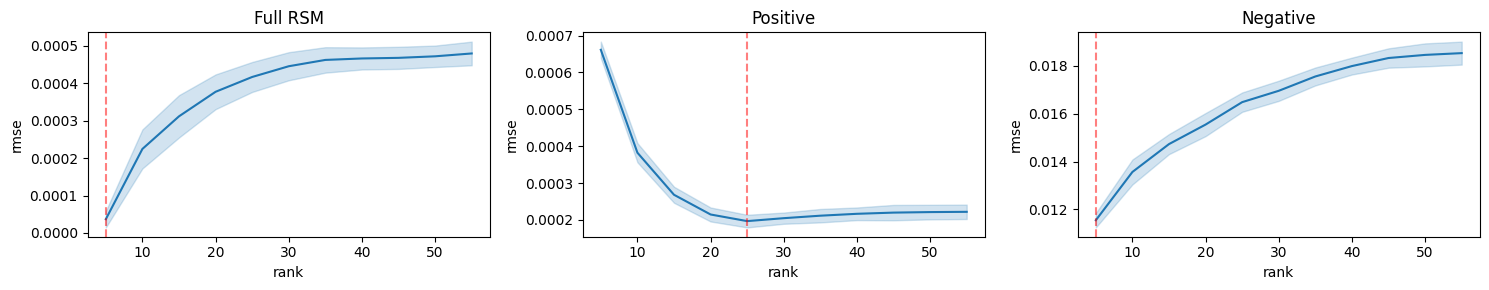

best rank for positive matrix: 25
best rank for negative matrix: 5
best rank for all matrix: 5


In [16]:
s_plus_plus, s_plus_minus, thresh_plus, mask_plus = median_matrix_split(rsm_pos)
ratio = 0.7
n_repeats = 10
df_full = find_best_rank(
    rsm_pos,
    range(5, 60, 5),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=n_repeats,
)
df_pos = find_best_rank(
    s_plus_plus,
    range(5, 60, 5),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=n_repeats,
)
df_neg = find_best_rank(
    s_plus_minus,
    range(5, 60, 5),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=n_repeats,
)
plot_rank_selection(df_full, df_pos, df_neg)

fraction of positive values: 0.5


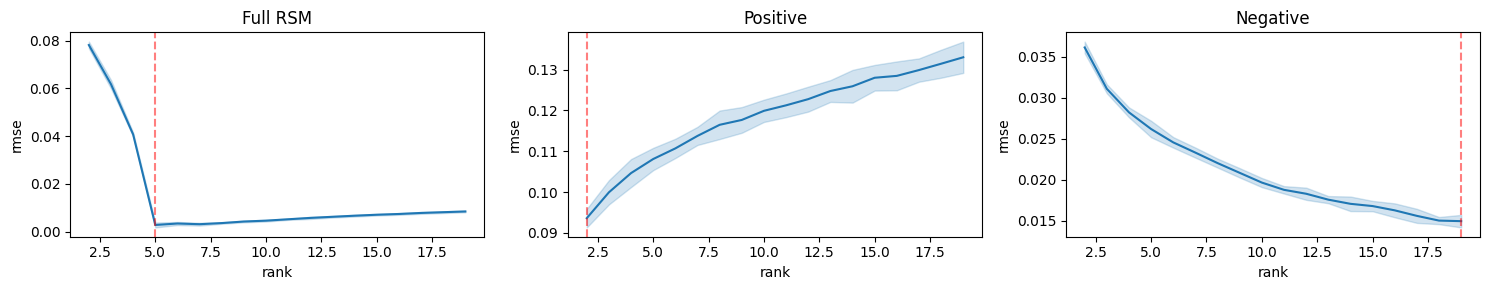

best rank for positive matrix: 2
best rank for negative matrix: 19
best rank for all matrix: 5


In [116]:
s_minus_plus, s_minus_minus, thresh_minus, mask_minus = median_matrix_split(rsm_neg)
ratio = 0.7
n_repeats = 10
df_full = find_best_rank(
    rsm_pos,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=n_repeats,
)
df_pos = find_best_rank(
    s_minus_plus,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=n_repeats,
)
df_neg = find_best_rank(
    s_minus_minus,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=n_repeats,
)
plot_rank_selection(df_full, df_pos, df_neg)

fraction of positive values: 0.5


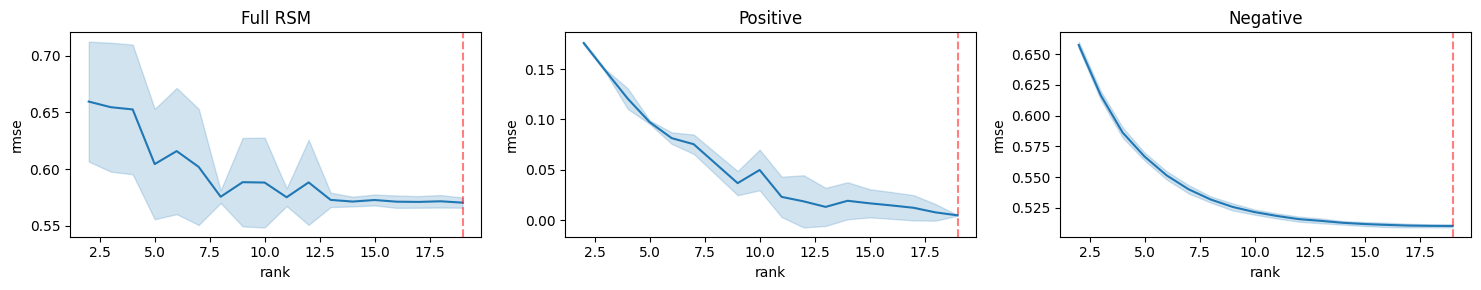

best rank for positive matrix: 19
best rank for negative matrix: 19
best rank for all matrix: 19


In [21]:
s_all_plus, s_all_minus, thresh_all, mask_all = median_matrix_split(rsm_all)
ratio = 0.7
n_repeats = 10
df_full = find_best_rank(
    rsm_all,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="cosine",
    n_repeats=n_repeats,
)
df_pos = find_best_rank(
    s_all_plus,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="cosine",
    n_repeats=n_repeats,
)
df_neg = find_best_rank(
    s_all_minus,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="cosine",
    n_repeats=n_repeats,
)
plot_rank_selection(df_full, df_pos, df_neg)

In [106]:
model = ADMM(rank=5, max_outer=30, w_inner=20, tol=0.0, verbose=True)
w_pos = model.fit_transform(s_plus, mask=mask)
w_neg = model.fit_transform(s_minus, mask=~mask)

s_hat = w_pos @ w_pos.T - w_neg @ w_neg.T
print(evar(rsm_all, s_hat))

0.28525310611100210.359081 | Evar: 0.994843 | Recon: 0.372463 | Penalty: 0.000520 | Lag: -0.013902149780166


### Below we check if there is a power law or somethig similar between the nuber of objects and the optimal training ratio

<Figure size 1920x1440 with 0 Axes>

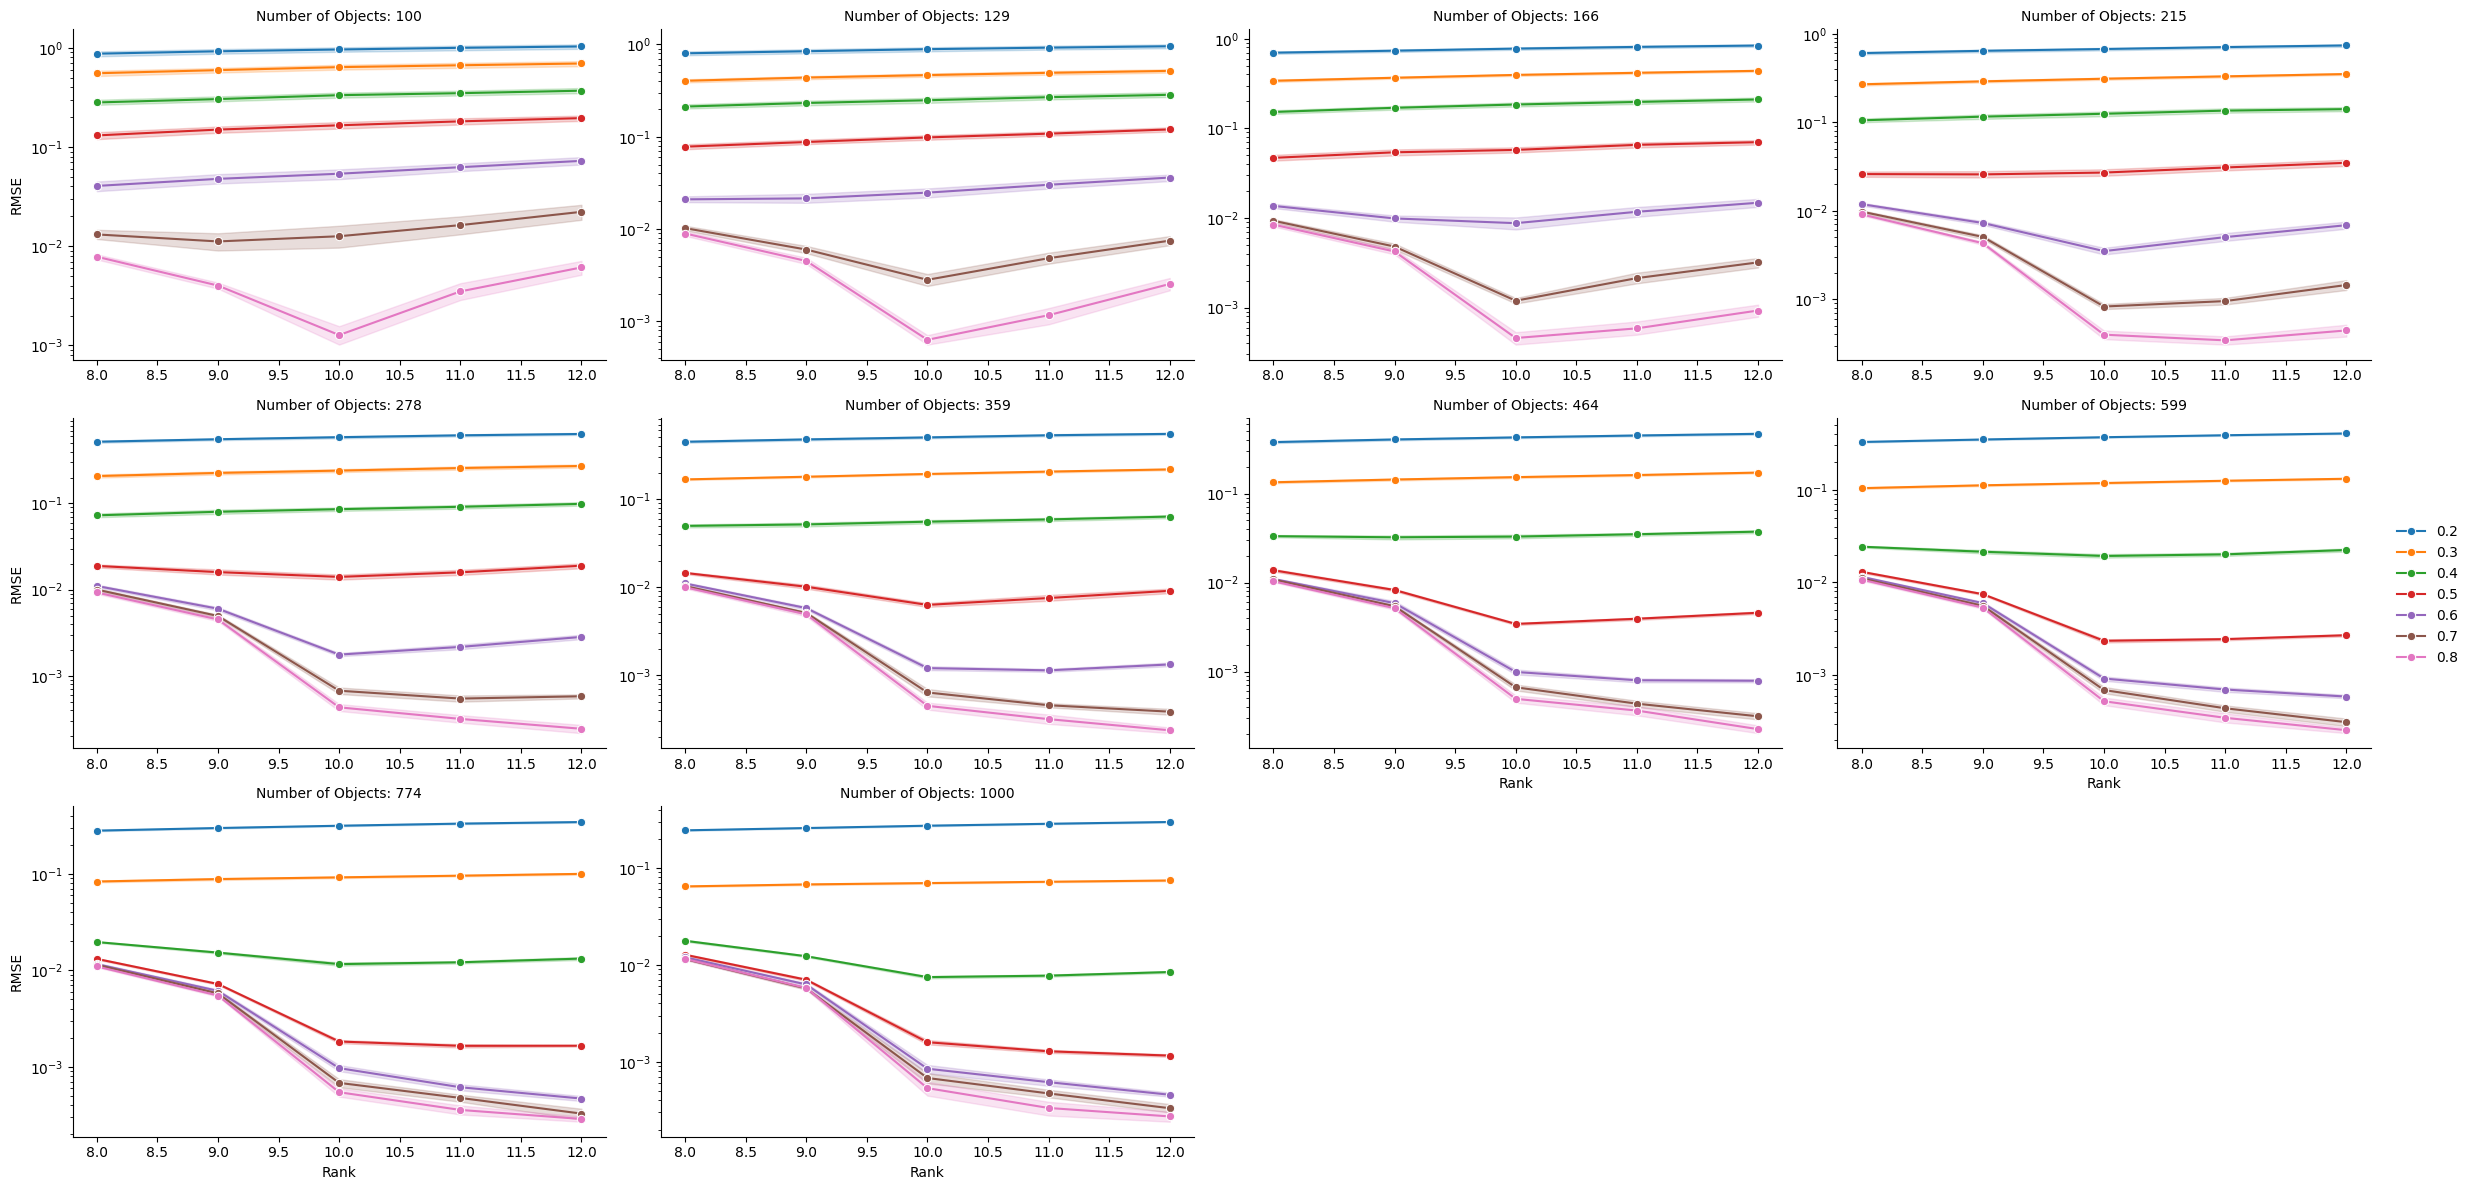

In [4]:
df = pd.read_csv("../results/rank_detection_full_results.csv")

plt.figure(dpi=300)  # Set higher DPI for better resolution
g = sns.FacetGrid(
    df, col="n_objects", col_wrap=4, height=4, aspect=1.5, sharey=False, sharex=False
)
g.map_dataframe(
    sns.lineplot,
    x="rank",
    y="mse",
    hue="train_ratio",
    marker="o",
    palette="tab10",
)
g.add_legend()
g.set_axis_labels("Rank", "RMSE")
g.set_titles("Number of Objects: {col_name}")

# Set y-axis to log scale for all subplots
for ax in g.axes.flat:
    ax.set_yscale("log")

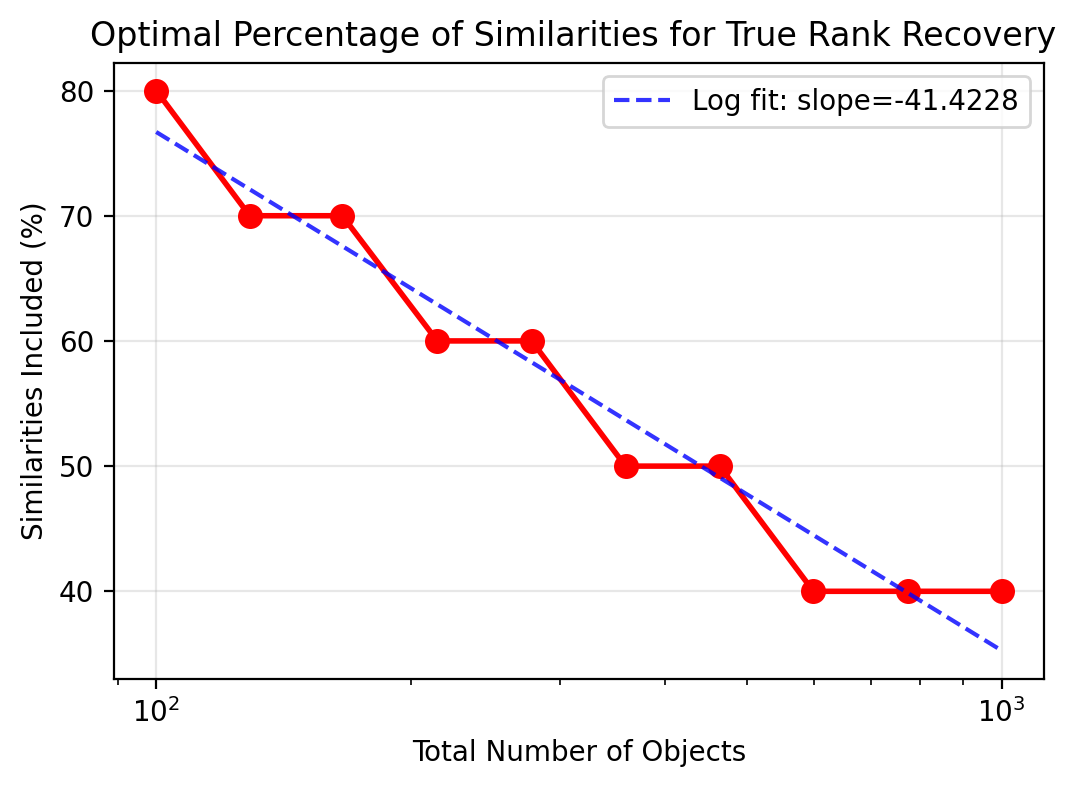

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the data
df = pd.read_csv("../results/rank_detection_full_results.csv")

# For each combination of n_objects, train_ratio, and trial_id, find the rank with minimum RMSE
best_ranks = df.groupby(["n_objects", "train_ratio", "trial_id"])["mse"].idxmin()
best_ranks_df = df.loc[best_ranks]

# Calculate accuracy (how often we recover the true rank) for each combination
best_ranks_df["correct_rank"] = best_ranks_df["rank"] == best_ranks_df["true_rank"]
accuracy_df = (
    best_ranks_df.groupby(["n_objects", "train_ratio"])["correct_rank"]
    .mean()
    .reset_index()
)

# Find optimal training ratio for each number of objects
optimal_ratios = []
object_counts = []

for n_obj in sorted(df["n_objects"].unique()):
    subset = accuracy_df[accuracy_df["n_objects"] == n_obj]
    best_ratio = subset.loc[subset["correct_rank"].idxmax(), "train_ratio"]
    optimal_ratios.append(best_ratio)
    object_counts.append(n_obj)

# Create the plot
plt.figure(figsize=(6, 4), dpi=200)
plt.plot(
    object_counts,
    np.array(optimal_ratios) * 100,
    "o-",
    linewidth=2,
    markersize=8,
    color="red",
)

# Add trend line
z = np.polyfit(np.log10(object_counts), np.array(optimal_ratios) * 100, 1)
p = np.poly1d(z)
plt.plot(
    object_counts,
    p(np.log10(object_counts)),
    "--",
    alpha=0.8,
    color="blue",
    label=f"Log fit: slope={z[0]:.4f}",
)

plt.xlabel("Total Number of Objects")
plt.ylabel("Similarities Included (%)")
plt.title("Optimal Percentage of Similarities for True Rank Recovery ")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xscale("log")

plt.show()

### Checking the rank selection for the things-monkey dataset

In [11]:
# things-monkye
dataset = load_dataset("things-monkey-2k")

rsm = dataset.rsm
rsm_pos = (rsm - rsm.min()) / (rsm.max() - rsm.min())
n = rsm.shape[0]
repeats = 3

ratio = 0.3
df_full = find_best_rank(
    rsm_pos,
    range(5, 45, 10),
    train_ratio=ratio,
    similarity_measure="cosine",
    n_repeats=repeats,
)

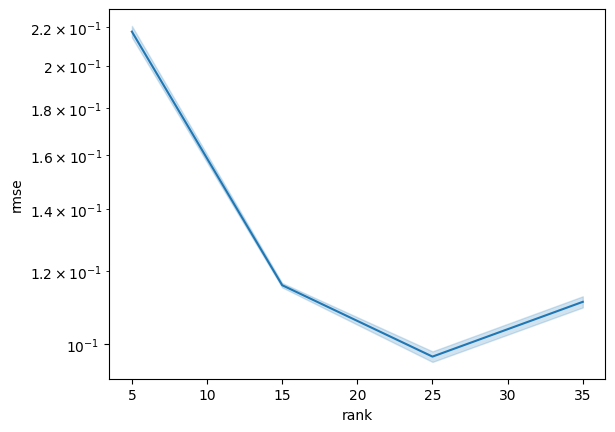

In [12]:
sns.lineplot(data=df_full, x="rank", y="rmse", errorbar="sd")
plt.yscale("log")
plt.show()

In [5]:
from srf.mixed.admm import ADMM
from srf.plotting import plot_images_from_embedding
from srf.datasets import load_dataset
from tools.rsa import compute_similarity

dataset = load_dataset("things-monkey-22k", min_reliab=0.1)

x = dataset.it
rsm = compute_similarity(x, x, "gaussian_kernel")

model = ADMM(rank=10, max_outer=10, w_inner=50, tol=0.0, verbose=True, rho=1.0)

w = model.fit_transform(rsm)


# fig = plot_images_from_embedding(w, dataset.filenames, top_k=10, dpi=100)

# # w_plus = model.fit_transform(s_plus)
# # w_minus = model.fit_transform(s_minus)

# # fig = plot_images_from_embedding(w_plus, images, top_k=10, dpi=100)
# # fig = plot_images_from_embedding(w_minus, images, top_k=10, dpi=100)

Sigma not provided, estimating from data using median distance
